In [26]:

import pandas as pd
import matplotlib.pyplot as plt
import re
from pathlib import Path
import seaborn as sns

In [27]:
# ============= CONFIG =============
TRIPS_PER_MONTH  = 18
DELAY_FACTOR_CAR = 1.35

# -------- locate BASE & DATA (works in notebook or script) --------
try:
    BASE = Path(__file__).resolve().parent        # .py script
except NameError:
    BASE = Path.cwd()                              # notebook / REPL

DATA_CANDIDATES = [BASE / "data", BASE.parent / "data"]
DATA = next((d for d in DATA_CANDIDATES if d.exists()), BASE / "data")

CITY_CSV       = DATA / "DelftTravelData_withCosts.csv"
PUMP_1x1       = DATA / "Avg_PumpPrice_Monthly.csv"
CAR_INFO_CANDS = [DATA / "Car_Information.csv", DATA / "car_information.csv"]

# ============= HELPERS =============
def must_exist(p: Path):
    if not p.exists():
        raise FileNotFoundError(str(p))

def smart_to_num(s: pd.Series) -> pd.Series:
    """
    Robust numeric parser:
    - strip € and NBSP
    - convert comma-decimal -> dot
    - remove thousands separators (space or dot between 3-digit groups)
    - keep the final decimal dot
    """
    s = s.astype(str).str.strip()
    s = s.str.replace("€", "", regex=False).str.replace("\u00A0", " ", regex=False)
    s = s.str.replace(",", ".", regex=False)  # decimal comma -> dot
    # remove thousand separators like "1 234" or "1.234" but keep decimal dot
    s = s.str.replace(r"(?<=\d)[\s\.](?=\d{3}(?:\D|$))", "", regex=True)
    return pd.to_numeric(s, errors="coerce")

def pick(df: pd.DataFrame, *alts) -> str | None:
    """Return the first matching column by normalized name; else None."""
    def norm(x): return re.sub(r"[^a-z0-9]", "", str(x).lower())
    cols_norm = {norm(c): c for c in df.columns}
    for a in alts:
        na = norm(a)
        if na in cols_norm:
            return cols_norm[na]
    return None

def load_pump_avg(path: Path) -> float:
    """Read any 1x1-ish CSV and return the first numeric found."""
    df = pd.read_csv(path, header=None, dtype=str)

    nums = []
    for v in df.values.flatten():
        s = ("" if pd.isna(v) else str(v)).strip().replace(",", ".")
        # accept ONLY pure numbers like 1.88 / 2 / 2.056 (no letters around)
        if re.fullmatch(r"[-+]?\d+(?:\.\d+)?", s):
            try:
                nums.append(float(s))
            except ValueError:
                pass

    # prefer a realistic fuel price range (€/L)
    for x in nums:
        if 0.5 <= x <= 5.0:
            return x
    if nums:
        return nums[-1]  # fallback: last numeric
    raise ValueError(f"No numeric fuel price found in {path.name}")

def load_car_info(candidates) -> dict:
    p = next((c for c in candidates if c.exists()), None)
    if p is None:
        raise FileNotFoundError(f"Car information file not found. Checked: {[str(x) for x in candidates]}")
    info = pd.read_csv(p, sep=";", engine="python")
    info.columns = [c.strip() for c in info.columns]
    if not {"Car information","Value"}.issubset(info.columns):
        raise ValueError(f"{p.name} must have columns 'Car information' and 'Value'")

    def norm(s: str) -> str: return re.sub(r"[ \-_/\.]", "", str(s).strip().lower())
    kv = {norm(k): str(v).replace(",", ".") for k, v in zip(info["Car information"], info["Value"])}

    # ---- consumption: accept either km/L or L/km ----
    cons_L_per_km = None
    for key in ["kilometersliter","kml","kmperliter","kilometerperliter","lperkm","literperkm","lkm"]:
        if key in kv:
            val = float(kv[key])
            if key in {"lperkm","literperkm","lkm"} or val <= 0.5:
                # Already L/km (typical ~0.04–0.12)
                cons_L_per_km = val
            else:
                # km/L (typical ~10–25) → convert to L/km
                cons_L_per_km = 1.0 / val
            break
    if cons_L_per_km is None:
        raise ValueError("Fuel consumption not found (expected km/L or L/km).")

    # maintenance €/month
    maint = None
    for key in ["maintenancecostsmonth","maintanencecostsmonth","maintenancepermonth","maintenancecostpermonth"]:
        if key in kv:
            maint = float(kv[key]); break
    if maint is None:
        raise ValueError("MaintenanceCosts/Month not found in car info.")

    return {"cons_L_per_km": cons_L_per_km, "maint_fixed_per_month": maint}

# ============= LOAD INPUTS =============
must_exist(CITY_CSV); must_exist(PUMP_1x1)
pump_price = load_pump_avg(PUMP_1x1)
car_info   = load_car_info(CAR_INFO_CANDS)

raw = pd.read_csv(CITY_CSV, dtype=str)  # read as text, we’ll parse numbers ourselves

# Detect columns flexibly
city_col   = pick(raw, "City", "city")
dist_col   = pick(raw, "Mean_Distance_to_Delft", "Mean Distance to Delft", "mean_dist_km")
time_col   = pick(raw, "Mean_Time_to_Delft", "Mean Time to Delft", "mean_time")
roadtax_c  = pick(raw, "Roadtax_eur_per_month", "Roadtax eur per month")
ins_c      = pick(raw, "Insurance_eur_per_month", "Insurance eur per month")
parking_c  = pick(raw, "ParkingPermit_eur_per_month", "ParkingPermit eur per month")

if city_col is None or dist_col is None or time_col is None:
    raise KeyError(f"Missing required columns. Found: {list(raw.columns)}")

# Parse numerics
city = pd.DataFrame({
    "City": raw[city_col],
    "mean_dist_km": smart_to_num(raw[dist_col]),
    "mean_time":    smart_to_num(raw[time_col]),
    "RoadTax_per_month":       smart_to_num(raw[roadtax_c]) if roadtax_c else 0.0,
    "Insurance_per_month":     smart_to_num(raw[ins_c])     if ins_c     else 0.0,
    "Parking_permit_per_month":smart_to_num(raw[parking_c]) if parking_c else 0.0,
})

if city["mean_dist_km"].median() > 1000:
    print("⚠️ Distances look too large; dividing by 100 to recover km with decimals.")
    city["mean_dist_km"] = city["mean_dist_km"] / 100.0


# Fill missing cost fields with 0
for c in ["RoadTax_per_month", "Insurance_per_month", "Parking_permit_per_month"]:
    city[c] = city[c].fillna(0)

city = city.set_index("City")

# ============= UNITS & FORMULAS =============
# If times look like seconds, convert to minutes
time_min_oneway = city["mean_time"] / 60.0 if city["mean_time"].median() > 1000 else city["mean_time"]

# Dist/time per month (round trips)
total_monthly_km = 2 * city["mean_dist_km"] * TRIPS_PER_MONTH
car_time = (time_min_oneway * 2 * DELAY_FACTOR_CAR * TRIPS_PER_MONTH).round(1)

# Costs
fuel_cost = pump_price * (car_info["cons_L_per_km"] * total_monthly_km)
car_cost = (
    fuel_cost
    + city["Insurance_per_month"]
    + city["RoadTax_per_month"]
    + city["Parking_permit_per_month"]
    + car_info["maint_fixed_per_month"]
).round(2)

# ============= SAVE OUTPUTS =============
# 1×N wide
pd.DataFrame([car_cost]).rename(index={0: "CarCost_EUR_per_month"})   .to_csv(DATA / "CarCost_1xN.csv", index=True)
pd.DataFrame([car_time]).rename(index={0: "CarTime_min_per_month"})   .to_csv(DATA / "CarTime_1xN.csv", index=True)

# tidy table (easy for plotting)
tidy = pd.DataFrame({
    "City": car_cost.index,
    "CarCost_EUR_per_month": car_cost.values,
    "CarTime_min_per_month": car_time.values
})
tidy.to_csv(DATA / "CarCostTime_tidy.csv", index=False)

# Small preview
print("✅ Saved:")
print(" -", DATA / "CarCost_1xN.csv")
print(" -", DATA / "CarTime_1xN.csv")
print(" -", DATA / "CarCostTime_tidy.csv")
print("\nPreview:")
print(tidy.head(13))


✅ Saved:
 - c:\Users\sapia\Desktop\TiL-6022-Group-Project\data\CarCost_1xN.csv
 - c:\Users\sapia\Desktop\TiL-6022-Group-Project\data\CarTime_1xN.csv
 - c:\Users\sapia\Desktop\TiL-6022-Group-Project\data\CarCostTime_tidy.csv

Preview:
                   City  CarCost_EUR_per_month  CarTime_min_per_month
0    Amsterdam Centraal                 357.77                 2867.4
1    Rotterdam Centraal                 221.94                  923.4
2     Den Haag Centraal                 207.12                  826.2
3      Utrecht Centraal                 372.74                 2575.8
4    Eindhoven Centraal                 521.18                 4957.2
5      Tilburg Centraal                 430.11                 3693.6
6        Almere Centrum                 410.90                 3402.0
7    Groningen Centraal                 831.18                 8310.6
8        Breda Centraal                 326.87                 2770.2
9     Nijmegen Centraal                 517.73                 495

In [28]:
# Load tTidy data
df = pd.read_csv("../data/CarCostTime_tidy.csv")

# Optional: sort by cost for clarity
df = df.sort_values("CarCost_EUR_per_month", ascending=False)

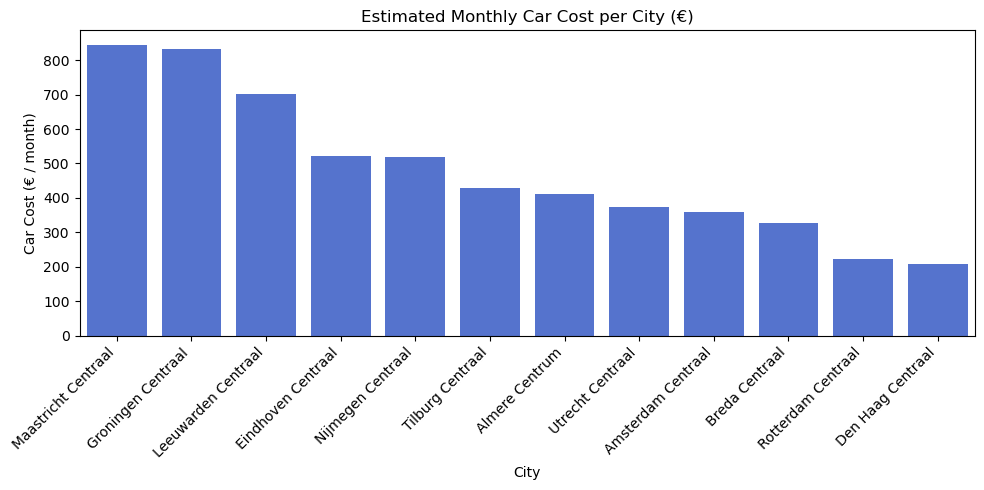

In [29]:
plt.figure(figsize=(10, 5))
sns.barplot(x="City", y="CarCost_EUR_per_month", data=df, color="royalblue")
plt.title("Estimated Monthly Car Cost per City (€)")
plt.xlabel("City")
plt.ylabel("Car Cost (€ / month)")
plt.xticks(rotation=45, ha="right")  # Rotate labels for readability
plt.tight_layout()
plt.show()


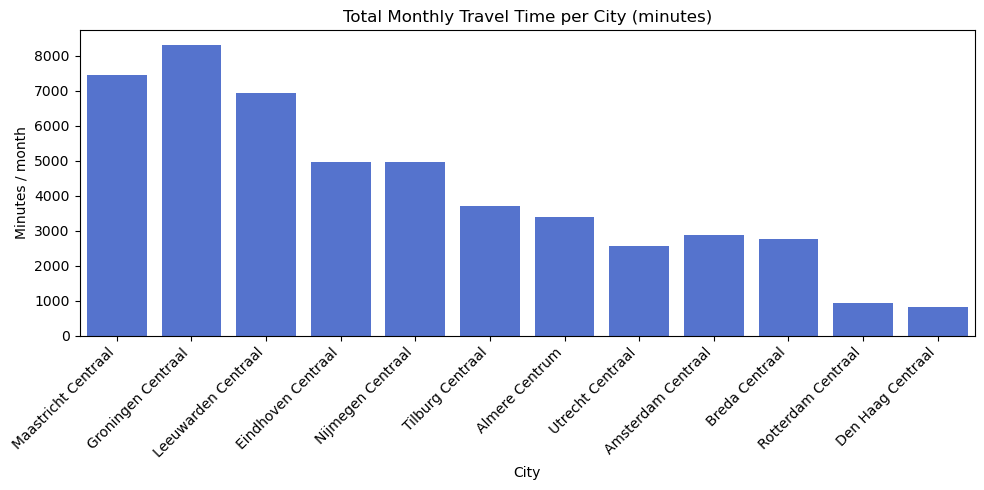

In [30]:
plt.figure(figsize=(10, 5))
sns.barplot(
    x="City",
    y="CarTime_min_per_month",
    data=df,
    color="royalblue"  # single solid color
)

plt.title("Total Monthly Travel Time per City (minutes)")
plt.xlabel("City")
plt.ylabel("Minutes / month")
plt.xticks(rotation=45, ha="right")  # rotate labels for readability
plt.tight_layout()
plt.show()



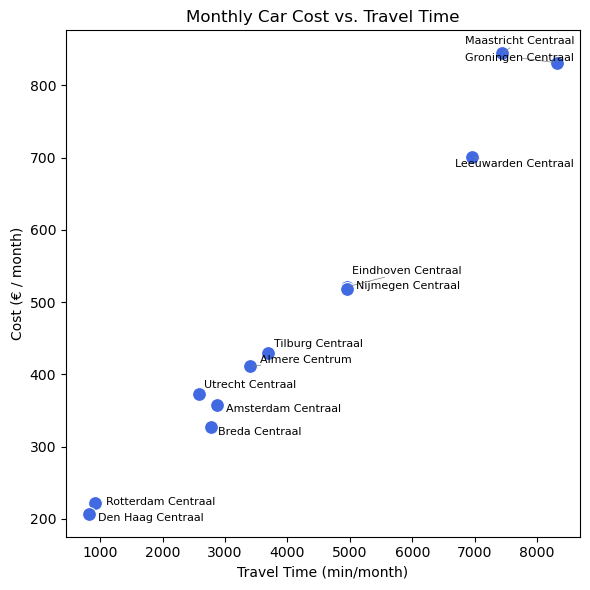

In [40]:
!pip install adjustText

from adjustText import adjust_text

plt.figure(figsize=(6, 6))
sns.scatterplot(
    x="CarTime_min_per_month",
    y="CarCost_EUR_per_month",
    data=df,
    s=100,
    color="royalblue"
)

texts = []
for i, row in df.iterrows():
    texts.append(
        plt.text(
            row.CarTime_min_per_month,
            row.CarCost_EUR_per_month,
            row.City,
            fontsize=8
        )
    )

adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

plt.title("Monthly Car Cost vs. Travel Time")
plt.xlabel("Travel Time (min/month)")
plt.ylabel("Cost (€ / month)")
plt.tight_layout()
plt.show()





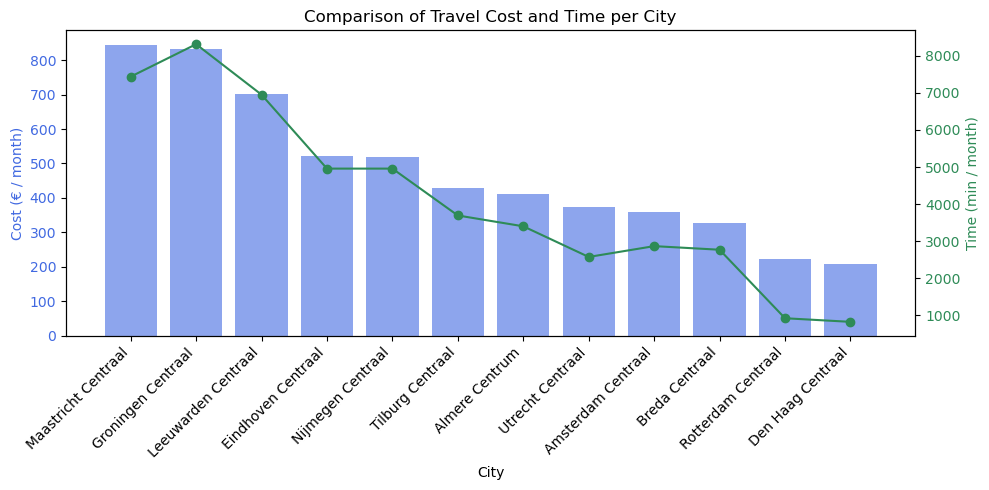

In [38]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# --- Left Y-axis (Cost) ---
color = "royalblue"
ax1.set_xlabel("City")
ax1.set_ylabel("Cost (€ / month)", color=color)
ax1.bar(df["City"], df["CarCost_EUR_per_month"], color=color, alpha=0.6, label="Cost (€ / month)")
ax1.tick_params(axis="y", labelcolor=color)
plt.xticks(rotation=45, ha="right")

# --- Right Y-axis (Time) ---
ax2 = ax1.twinx()
color = "seagreen"  # you can change this too if you like
ax2.plot(df["City"], df["CarTime_min_per_month"], color=color, marker="o", label="Time (min / month)")
ax2.set_ylabel("Time (min / month)", color=color)
ax2.tick_params(axis="y", labelcolor=color)

plt.title("Comparison of Travel Cost and Time per City")
fig.tight_layout()
plt.show()

